# Coal Plant Retirement Archetypes: A `Thema` Tutorial

This notebook walks through using **Thema** (topological data analysis) to categorize 198 U.S. coal plants into distinct retirement risk groups. Rather than choosing a single clustering method, we generate hundreds of candidate models via grid search, then select the optimal one using a policy-relevant metric: **Total Nameplate Capacity (TNC) variance**.

### The Workflow
1. **Preprocess** → Clean, impute, scale data ([`Planet`](https://krv-analytics.github.io/Thema/userGuides/preprocessing.html))
2. **Project** → Dimensionality reduction ([`Oort`](https://krv-analytics.github.io/Thema/userGuides/embedding.html))
3. **Graph** → Build graphs ([`Galaxy`](https://krv-analytics.github.io/Thema/userGuides/graphing.html))
4. **Select** → Filter by coverage, cluster by curvature distance, optimize for TNC variance
5. **Visualize** → Explore group characteristics ([`retire` docs](https://krv-analytics.github.io/retire/visualization_methods.html))

### Why TNC Variance?
**Total Nameplate Capacity** = max generation potential. For equitable policy design, we want capacity distributed evenly across groups (not dominated by a few giant plants). Lower variance = better balance. The elbow method finds the minimum number of groups that achieves low variance without over-fragmenting.

### Dataset
198 coal plants with ~50 features: operational (capacity, age), environmental (emissions), health/economic impacts, and policy context. Some have announced retirements; others don't. Goal: identify archetypes that reveal retirement vulnerability patterns.

## Setup & Imports

In [1]:
import os
import sys
from pathlib import Path

## --> FIX ME
sys.path.append("/Users/gathrid/Repos/thema_light/Thema")

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> We enable logging for INFO readouts. Feel free to comment out for no logging, or use DEBUG for more detail (especially if you are running on your own dataset + need to tune)
</div>

In [2]:
import thema
thema.enable_logging('INFO')

from thema.multiverse import Planet
from thema.multiverse import Oort
from thema.multiverse import Galaxy

Thema logging enabled at INFO level


## Directory Setup

Thema organizes outputs into three stages:
- **`clean/`**: Preprocessed datasets (imputed, scaled, ready for analysis)
- **`projections/`**: Dimensionality-reduced versions (t-SNE, PCA, etc.)
- **`graphs/`**: The actual TDA graph models (Mapper graphs)

We'll create these directories if they don't exist.

<div class="alert alert-block alert-warning"> 
<b>Warning:</b> Thema requires absolute paths
 </div>

In [3]:
base_dir = Path(os.getcwd()) / "thema_outputs"

clean_data_dir = base_dir / "clean"
projections_dir = base_dir / "projections"
graphs_dir = base_dir / "graphs"

for d in [clean_data_dir, projections_dir, graphs_dir]:
    d.mkdir(parents=True, exist_ok=True)


## Load Dataset
- Load raw dataset using `load_dataset()`
- Saving as tempfile for this demo so we do not write a permanent pickle file

In [4]:
import tempfile
import pandas as pd
from retire.data import load_dataset

raw_df = load_dataset()

# Create a temporary pickle file
with tempfile.NamedTemporaryFile(suffix=".pkl", delete=False) as tmp:
    tmp_path = tmp.name
    raw_df.to_pickle(tmp_path)

---

# Step 1: Preprocessing with `Planet`

[**`Planet`**](https://krv-analytics.github.io/Thema/userGuides/preprocessing.html) handles data cleaning: drops irrelevant columns, imputes missing values (distribution-aware methods), scales features, and creates multiple preprocessed versions ("Moons") with different random seeds for robustness.

## Planet Configuration

View [Thema Docs](https://krv-analytics.github.io/Thema/userGuides/preprocessing.html) for an overview on `Planet` configuration here. 

> Note our configuration below is specific to the dataset at hand. We have a lot of data that needs encoding, scaling, and repairing.

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> We use `numSamples=2` for the purposes of this demo, but recommend sampling more variations if significant portions of your dataset are missing
</div>

In [5]:
drop_columns = [ "ORISPL", "Plant Name", "Retirement Date", "UTLSRVID", "ret_STATUS", "Date of Last Unit or Planned Retirement", "Age at Retirement", "State", "eGRID subregion name", "coal_FUELS", "NONcoal_FUELS", "Renewables or Coal", "Percent difference", "Sector", "Utility Name", "Final Target Summary", "Attainment Year", "Interim Target(s) Summary", "Mandatory or Voluntary Target", "Target Scope", "Coal Debt Securitization Policy"]
impute_columns = ["Retirement Date","Date of Last Unit or Planned Retirement","Age at Retirement","State","2022 SO2 Emissions (tons)","2021 vs 2022 SO2 Emissions (%)","2022 SO2 Emission Rate (lb/mmBtu)","2022 NOX Emissions (tons)","2022 NOX Emission Rate (lb/mmBtu)","2022 CO2 Emissions (tons)","2021 vs 2022 CO2 Emissions (%)","2022 CO2 Emission Rate (lb/mmBtu)","2022 Hg Emissions (lbs)","2022 Hg Emission Rate (lb/TBtu)","Facility has one or more low-emitting EGUs (LEE) units that do not report hourly emissions","Hospital Admits, All Respiratory","Infant Mortality","Hospital Admits, Cardiovascular (except heart attacks)","$ Work Loss Days","$ Mortality (low estimate)","$ Asthma Exacerbation","PM 2.5 Emssions (tons)","PM 2.5 Emission Rate (lb/MWh)","2020 Net Cashflow","Average Cashflow","Forward Costs","Average PM Results (lb/mmBtu)","Cheapest Renewable Resource","Difference between cheapest renewables and coal ($/MWh)","Renewables or Coal","Percent difference","Ownership Type","Final Target Summary","Attainment Year","Interim Target(s) Summary","Mandatory or Voluntary Target","Target Scope",]
impute_methods = ["sampleNormal","sampleNormal","sampleNormal","mode","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","mode","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","sampleNormal","mode","sampleNormal","mode","sampleNormal","mode","mode","sampleNormal","mode","mode","mode",]

planit = Planet(
    data=tmp_path,
    dropColumns=drop_columns,
    imputeColumns=impute_columns,
    imputeMethods=impute_methods,
    scaler = "standard",

    seeds = [42, 13],
    #seeds="auto", ## --> auto-gen seeds if you are running many samplings
    numSamples=2,
)

planit.outDir = clean_data_dir

In [6]:
planit.fit()

thema.multiverse.system.inner.planet - INFO - Starting Planet.fit() - creating 2 Moon object(s)
thema.multiverse.system.inner.planet - INFO - Launching 2 Moon processes with max 2 workers


Progress:   0%|          | 0/2 [00:00<?, ?function/s]

thema.multiverse.system.inner.planet - INFO - Planet.fit() completed - all Moon objects processed


### 💡 Tuning Graphs by Number of Components

**Goal:** Control connected components to get meaningful representative graphs.

**t-SNE:**  
- Higher `perplexity` (50–100) → spreads points → fewer components.  
- Keep `dimensions` usually at 2D.

**Kepler Mapper:**  
- Fewer `nCubes` → coarser slicing → fewer components.  
- Higher `percOverlap` → more connected nodes → fewer components.  
- Larger `min_cluster_size` → merges small clusters → fewer components.

**Clustering Threshold:**  
- Higher threshold → merges more graphs → fewer representatives.  
- Lower threshold → preserves more distinct graphs → more representatives.

**Workflow:**  
1. Filter graphs by number of components.  
2. Adjust t-SNE & Mapper parameters to control fragmentation.  
3. Use clustering threshold to select a manageable number of representative graphs.  
4. Inspect representatives to ensure structural diversity.


---

# Step 2: Dimensionality Reduction with `Oort`

[**`Oort`**](https://krv-analytics.github.io/Thema/userGuides/embedding.html) projects our ~50D data into 2D for Mapper graph construction. We use **t-SNE** with multiple **perplexity** values to explore different structural emphases:
- **Low (2-10)**: Tight, local clusters
- **Medium (30-50)**: Balanced view
- **High (75-100)**: Global structure, broader groups

<div class="alert alert-block alert-warning"> 
<b>Warning:</b> UMAP (used in the study) has been deprecated in the Thema package due to non-deterministic results across versions, even with fixed seeds. We therefore use t-SNE as an alternative dimensionality reduction method.
 </div>

## Oort Configuration

In [7]:
projections_config = {
    "tsne": {
        "perplexity": [15, 30, 66],
        "dimensions": [2],
        "seed": [42],
    },

# ╭──────────────────────────────────────────────────────────────────╮
# │    Thema supports running multiple dim-reductions at a time      |
# ╰──────────────────────────────────────────────────────────────────╯

    # "pca": {
    #     "dimensions": [2, 3, 5, 10],
    #     "seed": [42],
    # },
}

oort = Oort(data=tmp_path, cleanDir=clean_data_dir, outDir=projections_dir, params=projections_config)

In [8]:
oort.fit()

Progress:   0%|          | 0/6 [00:00<?, ?function/s]

---

# Step 3: Graph Construction with `Galaxy`

[**`Galaxy`**](https://krv-analytics.github.io/Thema/userGuides/graphing.html) applies the Mapper algorithm: slice projections into overlapping regions, cluster plants within each region, connect clusters that share members. Result: a graph where **nodes** = plant clusters, **edges** = overlap, **connected components** = archetypes.

### Key Parameters
**`nCubes`**: Slicing granularity — fewer (5-10) = coarser groups; more (15-20) = finer detail.

**`percOverlap`**: Region overlap — low (0.5) = sparser graph; high (0.7) = denser connections.

**`min_cluster_size`**: Minimum plants per cluster — small (2) captures outliers; large (10) focuses on major groups.

**Grid:** 7 perplexity × 5 nCubes × 5 overlap × 3 cluster size × 5 Moons = **2,625 models**. Many fail (fragmentation, low coverage); we'll filter to ~700-1,000 viable candidates.

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> INFO logs may also show WARNING - <number> star saves failed, indicating empty simplicial complexes. This is not an error—it simply means certain combinations of dimensionality reduction and graph-construction parameters produced invalid graphs.
</div>

## Galaxy Configuration

In [9]:
kmapper_config = {
    "jmap": {
        "nCubes": [3, 5, 10, 20],
        "percOverlap": [0.55, 0.6, 0.65, 0.7],
        "minIntersection": [-1],
        "clusterer": [
            ["HDBSCAN", {"min_cluster_size": 2}],
            ["HDBSCAN", {"min_cluster_size": 6}],
        ],
    }
}

galaxy = Galaxy(data=tmp_path, cleanDir=clean_data_dir, projDir=projections_dir, outDir = graphs_dir, params=kmapper_config)


In [10]:
galaxy.fit()

thema.multiverse.universe.galaxy - INFO - Starting Galaxy fit with 1 star type(s)


Progress:   0%|          | 0/192 [00:00<?, ?function/s]

thema.multiverse.universe.galaxy - INFO - Galaxy fit complete: 158/192 (82.3%) stars successfully saved
thema.multiverse.universe.galaxy - WARNING - 34 star saves failed


# Filter Graphs

> View `unclustered` items with `jmapStar.get_unclustered_items()` via reading in an individual graph object

### Apply Coverage Filter (85% here)
As done in the study, we ensure graphs contain atleast 85% of total coal plants (i.e. at least 168 plants are clustered)

In [11]:
from thema.multiverse.universe.geodesics import _load_starGraphs
from thema.multiverse.universe.utils.starFilters import minimum_unique_items_filter

total_items = len(pd.read_pickle(next(Path(planit.outDir).glob("*.pkl"), None)).imputeData)
filter = total_items * 0.85

filterfunction = minimum_unique_items_filter(filter)
min_coverage = _load_starGraphs(dir = graphs_dir, graph_filter = filterfunction)
print(f"{len(min_coverage)} of {len(os.listdir(graphs_dir))} graphs meet the coverage threshold")

86 of 158 graphs meet the coverage threshold


#### Graph landscape after filtering
Number of connected components across all graphs that meet the coverage filter

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> For this demo, our hyperparameter grid search is sparse. Expanding the grid and adding intermediate values will produce a smoother, more structured distribution of models.
</div>

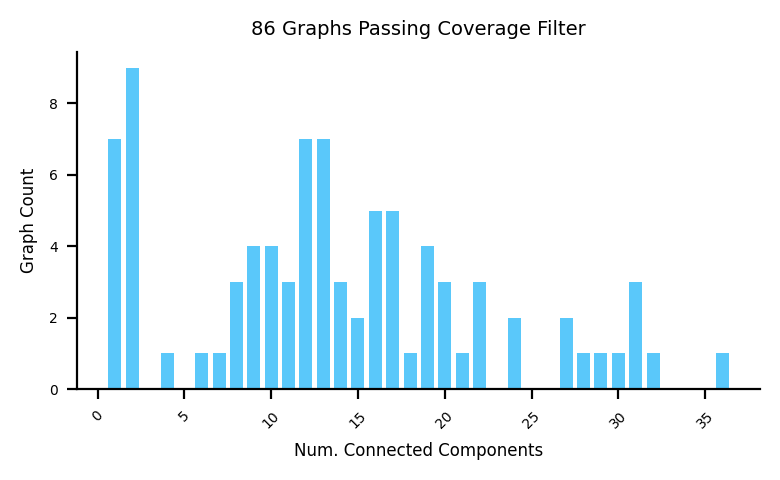

In [12]:
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(
    nx.number_connected_components(pd.read_pickle(f).starGraph.graph)
    for f in min_coverage
)

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)
bars = ax.bar(counts.keys(), counts.values(), color='#5AC8FA', edgecolor='none', width=0.75)

ax.set_xlabel("Num. Connected Components", fontsize=6, weight='medium')
ax.set_ylabel("Graph Count", fontsize=6, weight='medium')
ax.set_title(f"{sum(counts.values())} Graphs Passing Coverage Filter", fontsize=7)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

ax.tick_params(axis='x', rotation=45, labelsize=5)
ax.tick_params(axis='y', labelsize=5)

plt.tight_layout()
plt.show()


### 💡 Interpreting Results

***NOTE:*** Enable logging to see details: `thema.enable_logging('INFO')`

---

**Filter Results**  
- Example: `Filter results: 51/801 graphs passed the filter`  
- Out of all generated graphs, only those that meet a specific criterion (e.g., number of connected components) are selected.  
- In this case, **51 graphs** met the criterion out of **801 total graphs**.

**Galaxy Collapse (Clustering)**  
- Example: `Galaxy collapse complete: 4 representative stars selected`  
- The filtered graphs are clustered based on similarity (e.g., curvature distance).  
- Each cluster groups graphs that are structurally similar.

**Representative Selection**  
- From each cluster, **one graph is chosen as a representative**.  
- Here, **4 representative graphs** summarize the structural diversity of the 51 filtered graphs.

**Key Takeaway**  
- **Filter results** show how many graphs meet your criteria.  
- **Galaxy collapse** reduces redundancy, leaving a small set of **representative graphs**.


---

# Step 4: Model Selection

With ~700 viable models, many are structurally redundant. For each component count (4, 5, 6... groups), we:
1. Filter models with that exact count
2. Cluster by **curvature distance** (graph shape similarity)
3. Keep ~3 representatives per count ***or*** select via persistance landscape distance thresholds.
   1. `nReps` vs `distance_threshold` commented in the code below

This reduces ~700 → ~50-100 diverse models. Then, we select the optimal one by TNC variance (elbow method).

> ⚠️ **Note**: Pairwise graph distances are expensive—expect 2-5 minutes for this demo grid.

## Curvature-Based Clustering

In [13]:
from tqdm.notebook import tqdm
from thema.multiverse.universe.utils.starFilters import component_count_filter

selected_dict = {}
pbar = tqdm(sorted(counts.keys()), desc="Collapsing Graph Models", leave=True)

for val in pbar:
    filter_components = component_count_filter(val)
    n = counts[val]

    if n == 1:
        #pass
        selected_stars = _load_starGraphs(dir = list(min_coverage), graph_filter = filter_components)
        selected_dict[val] = list(selected_stars.keys())
    else:
        selected_stars = galaxy.collapse(
            metric="stellar_curvature_distance",

# ╭───────────────────────────────────────────────╮
# │     Representative Model Selection Method     |
# ╰───────────────────────────────────────────────╯
            # nReps= 3 if n >= 3 else n,
            distance_threshold=250,


            selector="max_nodes",
            filter_fn=filter_components,
            files=list(min_coverage)
        )

        selected_dict[val] = [v["star"] for v in selected_stars.values()]
    num_stars = len(selected_dict[val])

    pbar.set_description_str(
        f"| ✓ | Group {val:02d} | Models: {n} → {num_stars} "
    )


Collapsing Graph Models:   0%|          | 0/28 [00:00<?, ?it/s]

thema.multiverse.universe.galaxy - INFO - Distance matrix stats — min distance: 0.0000, max distance: 483.3036
thema.multiverse.universe.galaxy - INFO - Filter results: 7/86 graphs passed the filter
thema.multiverse.universe.galaxy - INFO - Galaxy collapse complete: 2 representative stars selected
thema.multiverse.universe.galaxy - INFO - Distance matrix stats — min distance: 0.0000, max distance: 256.7651
thema.multiverse.universe.galaxy - INFO - Filter results: 9/86 graphs passed the filter
thema.multiverse.universe.galaxy - INFO - Galaxy collapse complete: 1 representative stars selected
thema.multiverse.universe.galaxy - INFO - Distance matrix stats — min distance: 0.0000, max distance: 748.2424
thema.multiverse.universe.galaxy - INFO - Filter results: 3/86 graphs passed the filter
thema.multiverse.universe.galaxy - INFO - Galaxy collapse complete: 3 representative stars selected
thema.multiverse.universe.galaxy - INFO - Distance matrix stats — min distance: 0.0000, max distance: 7

## Helper Functions

Functions to calculate **TNC variance** (capacity distribution across groups) and detect the **elbow point** (optimal component count via second-derivative analysis). Adjust `smoothing` / `exclude_first_pct` in `elbow_heuristic()` if needed for your data.

In [14]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.interpolate import UnivariateSpline
from typing import Any, List, Tuple


def get_df_subset(model: Any, df: pd.DataFrame, component: int) -> pd.DataFrame:
    """
    Extract a subset of the dataset containing all plants belonging to a given group (component)
    in a JMAPStar model.

    Parameters
    ----------
    model : Any
        A JMAPStar model object (unpickled from the graph directory).
    df : pd.DataFrame
        The raw dataset of coal plants or the user's own dataset.
    component : int
        The index of the component (group) within the model to extract.

    Returns
    -------
    pd.DataFrame
        A subset of `df` containing only the plants that belong to the specified component.
    """
    nodes = model.starGraph.components[component].nodes
    members = [m for v in nodes for m in nodes[v]['membership']]
    return df.loc[df.index.intersection(members)]


def get_variance_of_group_totals(model: Any, df: pd.DataFrame, col: str) -> float:
    """
    Calculate how unevenly a chosen variable is distributed across all groups (components)
    in a model, using variance of group totals.

    i.e. calculate TNC for a single graph

    Parameters
    ----------
    model : Any
        A JMAPStar model object (unpickled from the graph directory).
    df : pd.DataFrame
        The raw dataset of coal plants or the user's own dataset.
    col : str
        The column name in `df` whose totals will be compared across groups.

    Returns
    -------
    float
        The variance (rounded to two decimals) of the group-level totals for the selected column.
    """
    sums = [get_df_subset(model, df, c)[col].sum() for c in model.starGraph.components]
    return round(np.var(sums), 2)


def make_run_measure_df(target_col: str, graph_paths: List[str]) -> pd.DataFrame:
    """
    Summarize how each model run (graph) performed across all components,
    showing both the number of components and variance of totals for a chosen variable.

    Parameters
    ----------
    target_col : str
        Column in the dataset (e.g., 'capacity_mw', 'generation_gwh', etc.) used for variance comparison.
    graph_paths : List[str]
        List of file paths to pickled JMAPStar model objects (graphs from the grid search).

    Returns
    -------
    pd.DataFrame
        A summary dataframe with one row per graph, containing:
        - 'num_components': total number of groups (connected components)
        - 'col_variance': variance of totals for the target column
        - 'file_path': relative file path of the graph
    """
    records = []
    for path in graph_paths:
        model = pd.read_pickle(path)
        num_comp = nx.number_connected_components(model.starGraph.graph)
        var = get_variance_of_group_totals(model, model.data, target_col)
        records.append({
            'num_components': num_comp,
            'col_variance': var,
            'file_path': '/'.join(path.split('/')[-2:])
        })
    return pd.DataFrame(records)


def elbow_heuristic(
    x: List[float],
    y: List[float],
    smoothing: float = 0.1,
    exclude_first_pct: float = 0.05,
    curvature_fraction: float = 0.8
) -> Tuple[float, float]:
    """
    Heuristic to detect the point of diminishing returns on a curve.

    Aggregates multiple y-values per x, normalizes axes, fits a smoothed spline,
    and returns the first x where curvature drops below a fraction of max curvature.

    Parameters
    ----------
    x : List[float]
        X-axis values (e.g., number of components or model parameters).
    y : List[float]
        Y-axis values (can contain multiple entries per x).
    smoothing : float, optional
        Smoothing factor for the spline fit (default 0.1).
    exclude_first_pct : float, optional
        Fraction of the smallest x-values to ignore (default 0).
    curvature_fraction : float, optional
        Fraction of maximum curvature to define “flattening” (default 0.8).

    Returns
    -------
    Tuple[float, float]
        The (x, y) coordinates of the heuristic elbow.
    """
    import numpy as np
    from scipy.interpolate import UnivariateSpline

    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)

    # Aggregate y-values per unique x
    unique_x = np.sort(np.unique(x))
    agg_y = np.array([y[x == xi].mean() for xi in unique_x])

    # Optionally exclude first few points
    exclude_n = max(1, int(len(unique_x) * exclude_first_pct))
    if exclude_n > 0:
        unique_x = unique_x[exclude_n:]
        agg_y = agg_y[exclude_n:]

    if len(unique_x) < 4:
        return unique_x[0], agg_y[0]

    x_norm = (unique_x - unique_x.min()) / (unique_x.max() - unique_x.min())
    y_norm = (agg_y - agg_y.min()) / (agg_y.max() - agg_y.min())
    spline = UnivariateSpline(x_norm, y_norm, s=smoothing, k=min(3, len(unique_x)-1))
    x_fine = np.linspace(0, 1, 200)
    curvature = np.abs(spline.derivative(n=2)(x_fine))

    # Find first point where curvature drops below fraction of max
    threshold = curvature_fraction * np.max(curvature)
    elbow_idx = np.argmax(curvature < threshold)
    elbow_x_norm = x_fine[elbow_idx]

    # Map back to original x
    elbow_x = elbow_x_norm * (unique_x.max() - unique_x.min()) + unique_x.min()
    closest_idx = np.argmin(np.abs(unique_x - elbow_x))
    return unique_x[closest_idx], agg_y[closest_idx]



## Calculate TNC Variance

Compute TNC variance (σ²) for each representative model. Lower variance = more even capacity distribution. Goal: balanced groups + manageable count.

In [15]:
file_paths = [str(item) for sublist in selected_dict.values() for item in sublist]
df = make_run_measure_df("Total Nameplate Capacity (MW)", file_paths)

## Find the Elbow

Plot **Components vs. Variance** and detect where adding groups yields diminishing returns (balance between complexity and utility). Select the model with lowest variance at the elbow point.

<div class="alert alert-block alert-info"> 
<b>NOTE:</b> For this demo, our hyperparameter grid search is sparse. Expanding the grid and adding intermediate values will produce a smoother, more structured distribution of models.
</div>

In [16]:
import plotly.graph_objects as go

elbow_x1, elbow_y1 = elbow_heuristic(df['num_components'].values, df['col_variance'].values, exclude_first_pct=0.15)
optimal_components = elbow_x1
lowest = df.loc[df['num_components'] == optimal_components].nsmallest(1, 'col_variance').iloc[0]

# --- Plotting ---
hovertext = ''.join([f'<b>{col}:</b> %{{customdata[{i}]}}<br>' for i, col in enumerate(df.columns)])

fig = go.Figure([
    go.Scatter(
        x=df['num_components'], y=df['col_variance'],
        mode='markers', name='Graph Models',
        marker=dict(size=5, opacity=0.75),
        customdata=df.values,
        hovertemplate='<b>Num Components:</b> %{x}<br><b>Col Variance:</b> %{y}<br>' + hovertext + '<extra></extra>'
    ),
    go.Scatter(
        x=[optimal_components]*2,
        y=[df['col_variance'].min(), df['col_variance'].max()],
        mode='lines', line=dict(color='red', dash='dash', width=0.7),
        name='Graph Elbow'
    ),
    go.Scatter(
        x=[lowest['num_components']], y=[lowest['col_variance']],
        mode='markers',
        marker=dict(size=12, color='rgba(255,0,0,0)', line=dict(color='red', width=2), symbol='circle'),
        name='Selected Model'
    )
])

fig.update_layout(
    title="Variance vs. Number of Groups",
    xaxis_title="Number of Components (Groups)",
    yaxis_title="TNC Variance (\u03C3\u00B2)",
    template="simple_white+gridon",
    width=1100, height=700,
    legend=dict(orientation='h', x=0.5, xanchor='center', y=-0.2, yanchor='top', bordercolor='black', borderwidth=1, bgcolor='white'),
    xaxis=dict(showgrid=True, minor=dict(ticklen=5, tickcolor='gray', showgrid=True), ticks="inside", tickwidth=1)
)

fig.show()

print(f"Optimal number of components: {optimal_components}")
print(f"Lowest variance at optimal components: {lowest['col_variance']}")
print(f"Selected model path: {lowest['file_path']}")


Optimal number of components: 8.0
Lowest variance at optimal components: 1572737604.09
Selected model path: graphs/jmap_clustererHDBSCANmin_cluster_size2_minIntersection-1_nCubes10_percOverlap0_7_id11_5.pkl


## Load Selected Model

In [17]:
selected_model = pd.read_pickle(os.path.join("thema_outputs", lowest['file_path']))

## quick check to ensure we are reading the correct model
assert nx.number_connected_components(selected_model.starGraph.graph) == optimal_components

---

# Step 5: Visualize & Interpret

The [`Explore`](https://krv-analytics.github.io/retire/visualization_methods.html) class visualizes graph structure, group characteristics, and retirement patterns. See **[this tutorial](https://github.com/Krv-Analytics/retire/blob/main/tutorials/using_explore.ipynb)** for detailed usage.

In [18]:
from retire import Explore
## --> raw_df loaded above via retire.dataset.load_dataset()
plotkit = Explore(raw_df=raw_df, G=selected_model.starGraph.graph)

## Graph Visualization

Nodes = plant clusters; edges = overlap. Node size typically reflects cluster membership count.

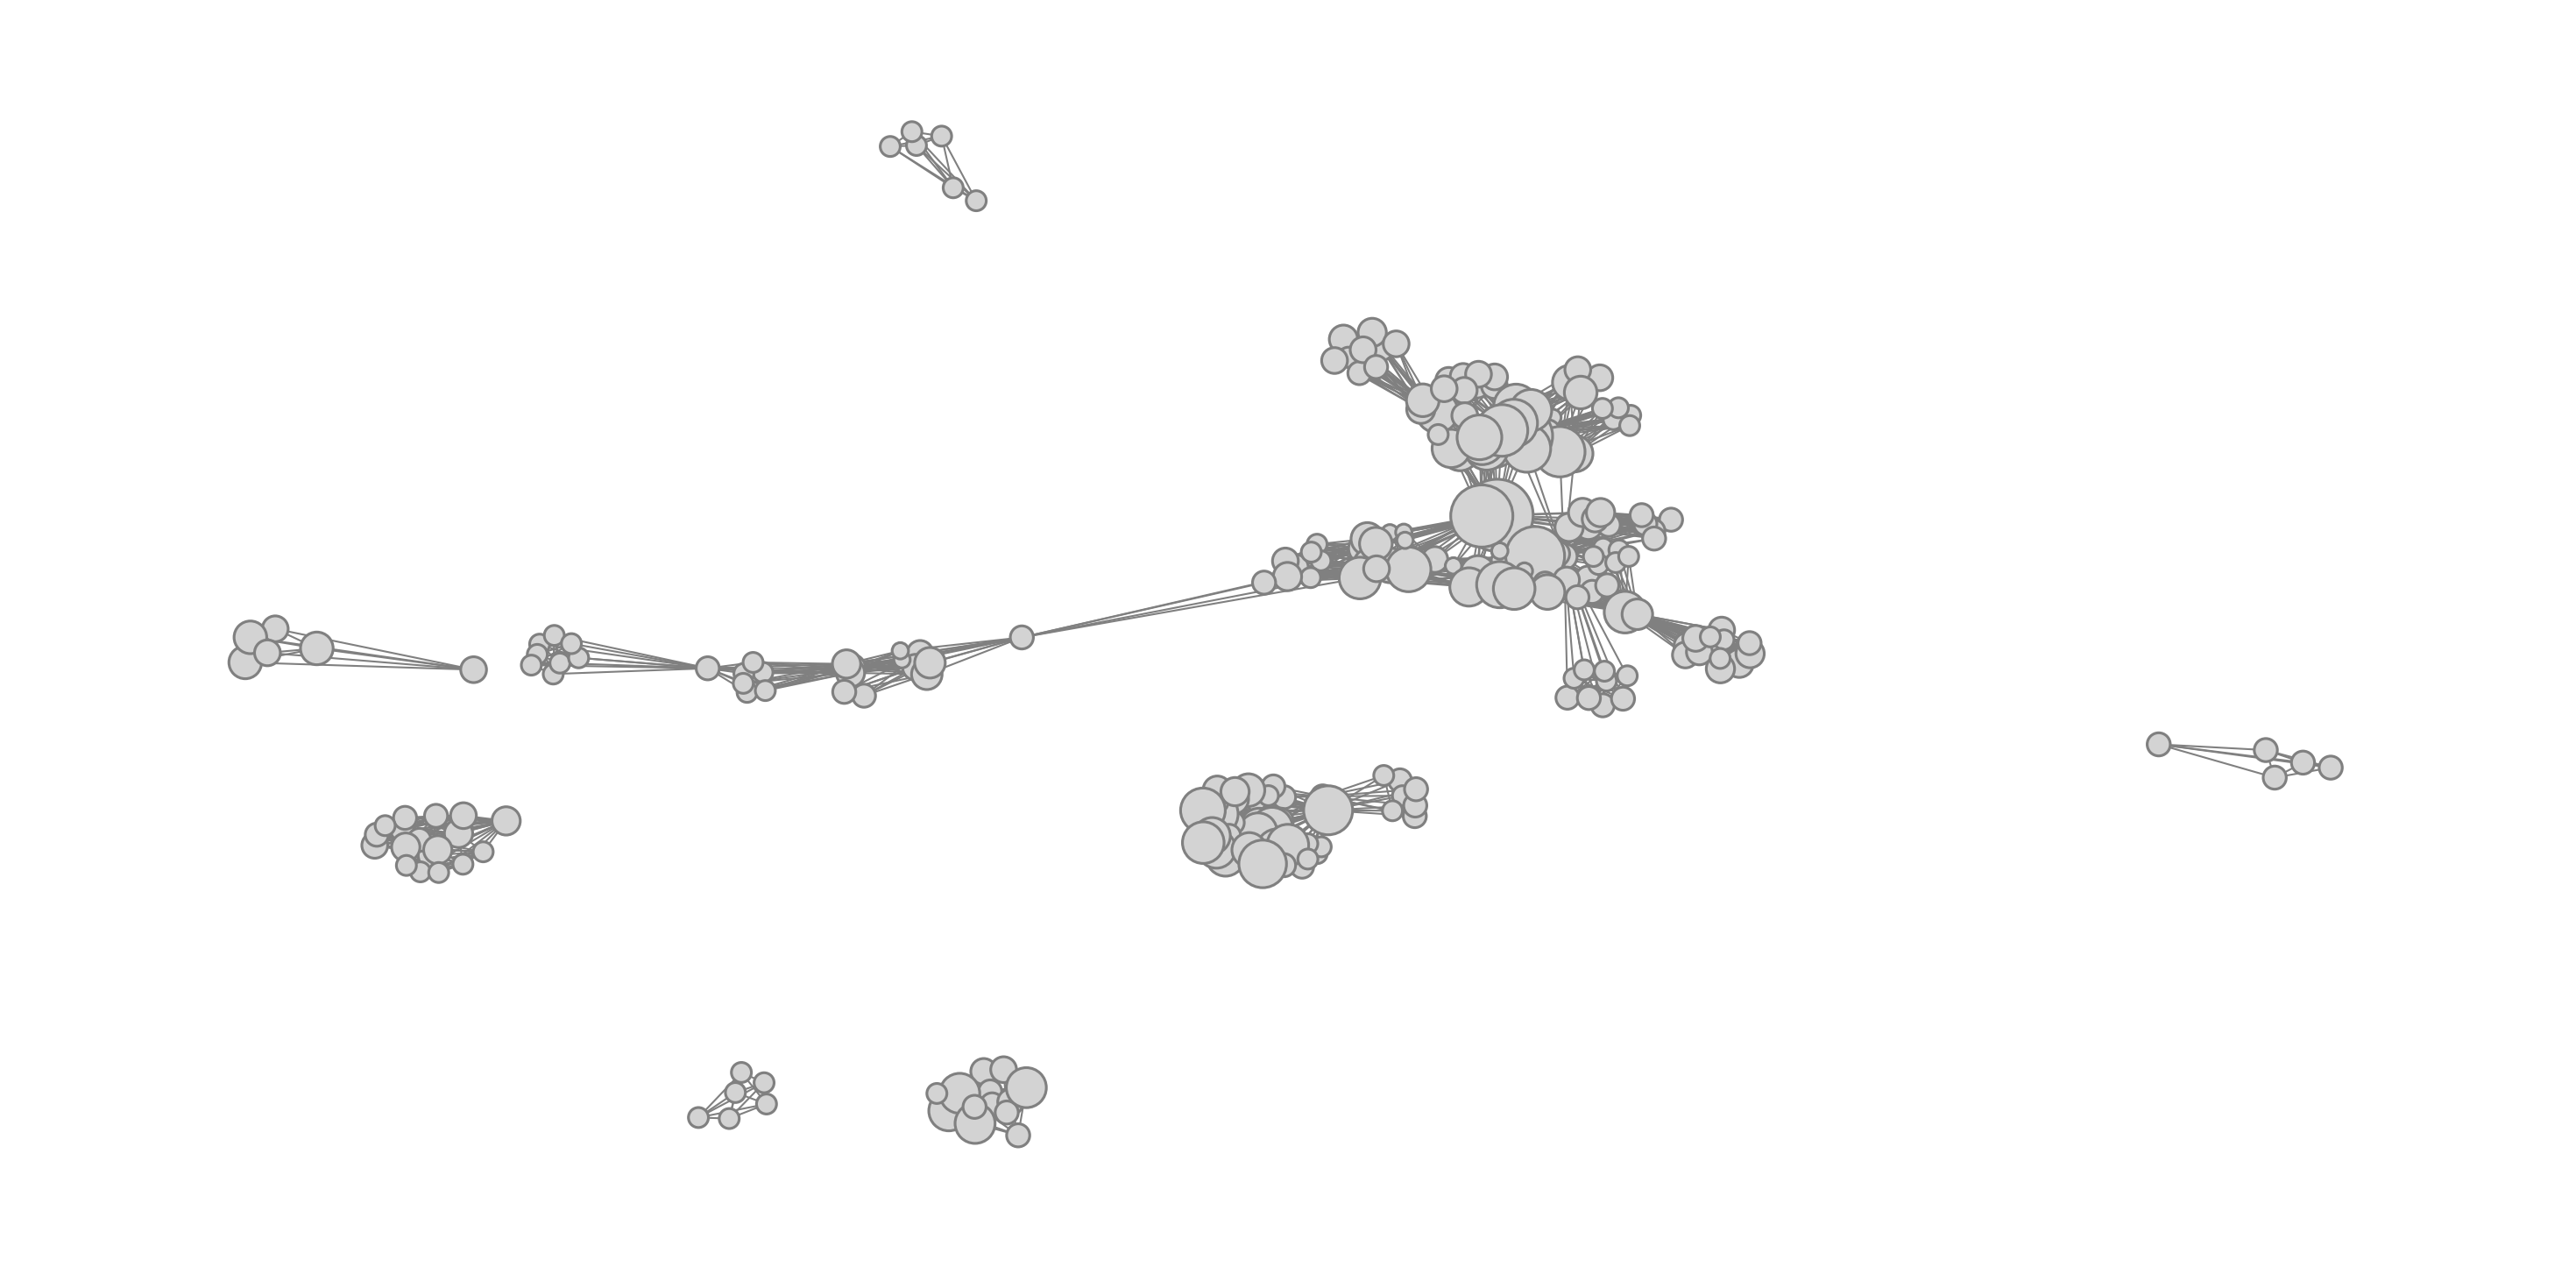

In [19]:
fig, ax = plotkit.drawGraph()

---

# Next Steps

**Analysis**: Characterize groups (mean/median by feature), calculate proximity scores (graph distance to retiring plants), validate against historical retirements.

**Extensions**: Try different projections (PCA), adjust coverage thresholds (85%), optimize for alternative metrics (emissions, regional balance), run sensitivity analysis (different seeds).

**Policy**: Identify barriers per archetype, design targeted strategies (financing, community transition), estimate impact, prioritize interventions.

---

**Resources**: [Thema Docs](https://krv-analytics.github.io/Thema/) | [retire Docs](https://krv-analytics.github.io/retire/) | [Original Study](LINK)